# The Boids!

## Flocking


> The aggregate motion of a flock of birds, a herd of land animals, or a school of fish is a beautiful and familiar
part of the natural world... The aggregate motion of the simulated flock is created by a distributed behavioral model much
like that at work in a natural flock; the birds choose their own course. Each simulated bird is implemented as an independent
actor that navigates according to its local perception of the dynamic environment, the laws of simulated physics that rule its
motion, and a set of behaviors programmed into it... The aggregate motion of the simulated flock is the result of the
dense interaction of the relatively simple behaviors of the individual simulated birds. 

-- Craig W. Reynolds, "Flocks, Herds, and Schools: A Distributed Behavioral Model", *Computer Graphics* **21** _4_ 1987, pp 25-34
See the [original paper](http://www.cs.toronto.edu/~dt/siggraph97-course/cwr87/)


* Collision Avoidance: avoid collisions with nearby flockmates
* Velocity Matching: attempt to match velocity with nearby flockmates
* Flock Centering: attempt to stay close to nearby flockmates

## Setting up the Boids

Our boids will each have an x velocity and a y velocity, and an x position and a y position.

We'll build this up in NumPy notation, and eventually, have an animated simulation of our flying boids.

In [1]:
import numpy as np

Let's start with simple flying in a straight line.

Our positions, for each of our N boids, will be an array, shape $2 \times N$, with the x positions in the first row,
and y positions in the second row.

In [2]:
boid_count = 10

We'll want to be able to seed our Boids in a random position.

We'd better define the edges of our simulation area:

In [3]:
limits = np.array([2000, 2000])

In [4]:
positions = np.random.rand(2, boid_count) * limits[:, np.newaxis]
positions

array([[1076.01779006, 1433.65275525,  255.79279949, 1656.18469266,
        1156.33318549,  600.6097317 , 1045.28076035, 1048.24604685,
        1226.85575771, 1281.21291512],
       [1353.91600134,   23.69453707,  443.28115887,  184.86751829,
         671.37028732,  986.3118934 ,  911.04848718, 1009.65326664,
        1178.42821381,  310.52956282]])

In [5]:
positions.shape

(2, 10)

We used **broadcasting** with np.newaxis to apply our upper limit to each boid.
`rand` gives us a random number between 0 and 1. We multiply by our limits to get a number up to that limit.

In [6]:
limits[:, np.newaxis]

array([[2000],
       [2000]])

In [7]:
limits[:, np.newaxis].shape

(2, 1)

In [8]:
np.random.rand(2, boid_count).shape

(2, 10)

So we multiply a $2\times1$ array by a $2 \times 10$ array -- and get a $2\times 10$ array.

Let's put that in a function:

In [9]:
def new_flock(count, lower_limits, upper_limits):
    width = upper_limits - lower_limits
    return lower_limits[:, np.newaxis] + np.random.rand(2, count) * width[:, np.newaxis]

For example, let's assume that we want our initial positions to vary between 100 and 200 in the x axis, and 900 and 1100 in the y axis. We can generate random positions within these constraints with:
```python
positions = new_flock(boid_count, np.array([100, 900]), np.array([200, 1100]))
```

But each bird will also need a starting velocity. Let's make these random too:

We can reuse the `new_flock` function defined above, since we're again essentially just generating random numbers from given limits. This saves us some code, but keep in mind that using a function for something other than what its name indicates can become confusing!

Here, we will let the initial x velocities range over $[0, 10]$ and the y velocities over $[-20, 20]$.

In [10]:
velocities = new_flock(boid_count, np.array([0, -20]), np.array([10, 20]))
velocities

array([[  9.87301629,   1.30232787,   5.06429355,   3.04029988,
          2.70300253,   5.39171364,   2.65926723,   8.6557001 ,
          9.16162315,   5.08543371],
       [ -8.06756307,   7.13995114, -11.81110971,  12.21594245,
          7.39126954,  -4.15062709,  16.36324969,  15.40416467,
          4.19850725,   1.12680596]])

## Flying in a Straight Line

Now we see the real amazingness of NumPy: if we want to move our *whole flock* according to

$\delta_x = \delta_t \cdot \frac{dv}{dt}$

we just do:

In [11]:
positions += velocities

## Matplotlib Animations

So now we can animate our Boids using the matplotlib animation tools. All we have to do is import the relevant libraries:

In [12]:
from matplotlib import animation
from matplotlib import pyplot as plt

%matplotlib inline

Then, we make a static plot, showing our first frame:

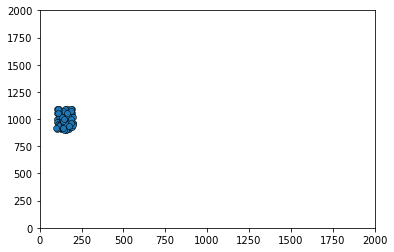

In [13]:
# create a simple plot
# initial x position in [100, 200], initial y position in [900, 1100]
# initial x velocity in [0, 10], initial y velocity in [-20, 20]
positions = new_flock(100, np.array([100, 900]), np.array([200, 1100]))
velocities = new_flock(100, np.array([0, -20]), np.array([10, 20]))

figure = plt.figure()
axes = plt.axes(xlim=(0, limits[0]), ylim=(0, limits[1]))
scatter = axes.scatter(
    positions[0, :], positions[1, :], marker="o", edgecolor="k", lw=0.5
)
scatter

Then, we define a function which **updates** the figure for each timestep

In [14]:
def update_boids(positions, velocities):
    positions += velocities


def animate(frame):
    update_boids(positions, velocities)
    scatter.set_offsets(positions.transpose())

Call `FuncAnimation`, and specify how many frames we want:

In [15]:
anim = animation.FuncAnimation(figure, animate, frames=50, interval=50)

Save out the figure:

In [20]:
positions = new_flock(100, np.array([100, 900]), np.array([200, 1100]))
velocities = new_flock(100, np.array([0, -20]), np.array([10, 20]))

#anim.save("boids_1.mp4")

anim.save('animation.gif', writer='PillowWriter', fps=2)

MovieWriter PillowWriter unavailable; using Pillow instead.


And download the [saved animation](http://github-pages.ucl.ac.uk/rsd-engineeringcourse/ch01data/boids_1.mp4).

You can even view the results directly in the notebook.

In [21]:
from IPython.display import HTML

positions = new_flock(100, np.array([100, 900]), np.array([200, 1100]))
velocities = new_flock(100, np.array([0, -20]), np.array([10, 20]))
HTML(anim.to_jshtml())

## Fly towards the middle

Boids try to fly towards the middle:

In [22]:
positions = new_flock(4, np.array([100, 900]), np.array([200, 1100]))
velocities = new_flock(4, np.array([0, -20]), np.array([10, 20]))

In [23]:
positions

array([[ 163.67244267,  107.0495264 ,  111.18074737,  185.8457265 ],
       [1004.97585667, 1057.23168366, 1049.18147537, 1069.31908423]])

In [24]:
velocities

array([[  5.86000653,   1.99197483,   0.10838141,   0.134988  ],
       [ -4.85987769, -13.38611887, -12.87269717,  -4.87336843]])

In [25]:
middle = np.mean(positions, 1)
middle

array([ 141.93711073, 1045.17702498])

In [26]:
direction_to_middle = positions - middle[:, np.newaxis]
direction_to_middle

array([[ 21.73533194, -34.88758433, -30.75636337,  43.90861576],
       [-40.20116831,  12.05465868,   4.00445039,  24.14205925]])

This is easier and faster than:

``` python
for bird in birds:
    for dimension in [0, 1]:
        direction_to_middle[dimension][bird] = positions[dimension][bird] - middle[dimension]
```

In [27]:
move_to_middle_strength = 0.01
velocities = velocities - direction_to_middle * move_to_middle_strength

Let's update our function, and animate that:

In [28]:
def update_boids(positions, velocities):
    move_to_middle_strength = 0.01
    middle = np.mean(positions, 1)
    direction_to_middle = positions - middle[:, np.newaxis]
    velocities -= direction_to_middle * move_to_middle_strength
    positions += velocities

In [29]:
def animate(frame):
    update_boids(positions, velocities)
    scatter.set_offsets(positions.transpose())

In [30]:
anim = animation.FuncAnimation(figure, animate, frames=50, interval=50)

In [31]:
positions = new_flock(100, np.array([100, 900]), np.array([200, 1100]))
velocities = new_flock(100, np.array([0, -20]), np.array([10, 20]))
HTML(anim.to_jshtml())

## Avoiding collisions

We'll want to add our other flocking rules to the behaviour of the Boids.

We'll need a matrix giving the distances between each bird. This should be $N \times N$.

In [32]:
positions = new_flock(4, np.array([100, 900]), np.array([200, 1100]))
velocities = new_flock(4, np.array([0, -20]), np.array([10, 20]))

We might think that we need to do the X-distances and Y-distances separately:

In [33]:
xpos = positions[0, :]

In [34]:
xsep_matrix = xpos[:, np.newaxis] - xpos[np.newaxis, :]

In [35]:
xsep_matrix.shape

(4, 4)

In [36]:
xsep_matrix

array([[  0.        , -12.83419062, -43.90505234, -43.28235454],
       [ 12.83419062,   0.        , -31.07086172, -30.44816392],
       [ 43.90505234,  31.07086172,   0.        ,   0.6226978 ],
       [ 43.28235454,  30.44816392,  -0.6226978 ,   0.        ]])

But in NumPy we can be cleverer than that, and make a $2 \times N \times N$ matrix of separations:

In [37]:
separations = positions[:, np.newaxis, :] - positions[:, :, np.newaxis]

In [38]:
separations.shape

(2, 4, 4)

And then we can get the sum-of-squares $\delta_x^2 + \delta_y^2$ like this:

In [39]:
squared_displacements = separations * separations

In [40]:
square_distances = np.sum(squared_displacements, 0)

In [41]:
square_distances

array([[    0.        ,   618.50108867,  2169.52108039, 19324.69495359],
       [  618.50108867,     0.        ,  2323.63861898, 24460.40377741],
       [ 2169.52108039,  2323.63861898,     0.        , 13584.61751297],
       [19324.69495359, 24460.40377741, 13584.61751297,     0.        ]])

Now we need to find birds that are too close:

In [42]:
alert_distance = 2000
close_birds = square_distances < alert_distance
close_birds

array([[ True,  True, False, False],
       [ True,  True, False, False],
       [False, False,  True, False],
       [False, False, False,  True]])

Find the direction distances **only** to those birds which are too close:

In [43]:
separations_if_close = np.copy(separations)
far_away = np.logical_not(close_birds)

Set `x` and `y` values in `separations_if_close` to zero if they are far away:

In [44]:
separations_if_close[0, :, :][far_away] = 0
separations_if_close[1, :, :][far_away] = 0
separations_if_close

array([[[  0.        ,  12.83419062,   0.        ,   0.        ],
        [-12.83419062,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ]],

       [[  0.        , -21.30222148,   0.        ,   0.        ],
        [ 21.30222148,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ]]])

And fly away from them:

In [45]:
np.sum(separations_if_close, 2)

array([[ 12.83419062, -12.83419062,   0.        ,   0.        ],
       [-21.30222148,  21.30222148,   0.        ,   0.        ]])

In [46]:
velocities = velocities + np.sum(separations_if_close, 2)

Now we can update our animation:

In [47]:
def update_boids(positions, velocities):
    move_to_middle_strength = 0.01
    middle = np.mean(positions, 1)
    direction_to_middle = positions - middle[:, np.newaxis]
    velocities -= direction_to_middle * move_to_middle_strength

    separations = positions[:, np.newaxis, :] - positions[:, :, np.newaxis]
    squared_displacements = separations * separations
    square_distances = np.sum(squared_displacements, 0)
    alert_distance = 100
    far_away = square_distances > alert_distance
    separations_if_close = np.copy(separations)
    separations_if_close[0, :, :][far_away] = 0
    separations_if_close[1, :, :][far_away] = 0
    velocities += np.sum(separations_if_close, 1)

    positions += velocities

In [51]:
def animate(frame):
    update_boids(positions, velocities)
    scatter.set_offsets(positions.transpose())


anim = animation.FuncAnimation(figure, animate, frames=50, interval=50)

positions = new_flock(100, np.array([100, 900]), np.array([200, 1100]))
velocities = new_flock(100, np.array([0, -20]), np.array([10, 20]))
HTML(anim.to_jshtml())

## Match speed with nearby birds

This is pretty similar:

In [52]:
def update_boids(positions, velocities):
    move_to_middle_strength = 0.01
    middle = np.mean(positions, 1)
    direction_to_middle = positions - middle[:, np.newaxis]
    velocities -= direction_to_middle * move_to_middle_strength

    separations = positions[:, np.newaxis, :] - positions[:, :, np.newaxis]
    squared_displacements = separations * separations
    square_distances = np.sum(squared_displacements, 0)
    alert_distance = 100
    far_away = square_distances > alert_distance
    separations_if_close = np.copy(separations)
    separations_if_close[0, :, :][far_away] = 0
    separations_if_close[1, :, :][far_away] = 0
    velocities += np.sum(separations_if_close, 1)

    velocity_differences = velocities[:, np.newaxis, :] - velocities[:, :, np.newaxis]
    formation_flying_distance = 10000
    formation_flying_strength = 0.125
    very_far = square_distances > formation_flying_distance
    velocity_differences_if_close = np.copy(velocity_differences)
    velocity_differences_if_close[0, :, :][very_far] = 0
    velocity_differences_if_close[1, :, :][very_far] = 0
    velocities -= np.mean(velocity_differences_if_close, 1) * formation_flying_strength

    positions += velocities

In [50]:
def animate(frame):
    update_boids(positions, velocities)
    scatter.set_offsets(positions.transpose())


anim = animation.FuncAnimation(figure, animate, frames=200, interval=50)


positions = new_flock(100, np.array([100, 900]), np.array([200, 1100]))
velocities = new_flock(100, np.array([0, -20]), np.array([10, 20]))
HTML(anim.to_jshtml())

Hopefully the power of NumPy should be pretty clear now. This would be **enormously slower** and, I think, harder to understand using traditional lists.